In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np

p_e = 0.2
N = 10000

delta = np.random.uniform(0,1,size=N)


z = np.random.binomial(1., p=0.5, size=N)
e = np.random.binomial(1., p=p_e, size=N)
u = np.random.normal(size=N)
x = (e==1)*np.random.binomial(1, p=1. / (1. + np.exp(-delta + u))) + (e==0)*z
y = u + delta*x + np.random.normal(size=N)

df = pd.DataFrame({"X": x, "Z": z, "E": e, "U": u, "Y": y})

In [2]:
def naive_effect(df):
    return df.groupby('X').mean()['Y'][1] - df.groupby('X').mean()['Y'][0]

def wald_effect(df):
    return np.cov(df['Y'], df['Z'])[0][1] / np.cov(df['X'], df['Z'])[0][1]

naive_effect(df), wald_effect(df)

(0.3262012127683049, 0.46514394441441365)

In [3]:
import statsmodels.api as sm

df['intercept'] = 1.
model = sm.OLS(endog=df['X'], exog=df[['Z', 'intercept']])
result = model.fit()
df['$\hat{X}$'] = result.predict()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                 1.754e+04
Date:                Tue, 16 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:46:02   Log-Likelihood:                -2179.3
No. Observations:               10000   AIC:                             4363.
Df Residuals:                    9998   BIC:                             4377.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z              0.7970      0.006    132.423      0.000       0.785       0.809
intercept      0.1220      0.004     28.483      0.000       0.114       0.130
==============================================================================
Omnibus:                     1243.775   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10354.609
Skew:                           0.307   Prob(JB):                         0.00
Kurtosis:                       7.947   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
model = sm.OLS(endog=df['Y'], exog=df[['$\hat{X}$', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     176.5
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           6.10e-40
Time:                        19:46:40   Log-Likelihood:                -17518.
No. Observations:               10000   AIC:                         3.504e+04
Df Residuals:                    9998   BIC:                         3.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
$\hat{X}$      0.4651      0.035     13.286      0.000       0.397       0.534
intercept     -0.0078      0.023     -0.339      0.734      -0.053       0.037
==============================================================================
Omnibus:                        1.164   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                1.140
Skew:                           0.003   Prob(JB):                        0.566
Kurtosis:                       3.052   Cond. No.                         3.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
result.params

$\hat{X}$    0.524230
intercept   -0.032562
dtype: float64

In [6]:
def tsls_effect(df):
    df['intercept'] = 1.
    model = sm.OLS(endog=df['X'], exog=df[['Z', 'intercept']])
    result = model.fit()
    df['$\hat{X}$'] = result.predict()
    model = sm.OLS(endog=df['Y'], exog=df[['$\hat{X}$', 'intercept']])
    result = model.fit()
    return result.params['$\hat{X}$']

tsls_effect(df)

0.46514394441441637

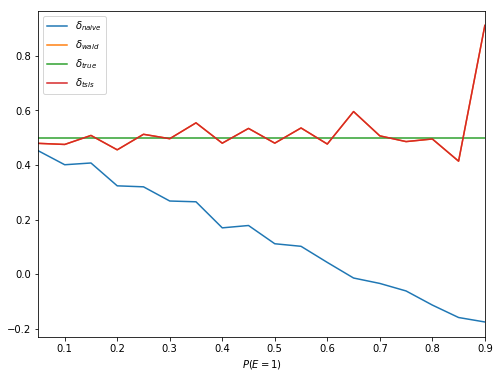

In [7]:
N = 1000
bootstrap_samples = 30

results = []
for p_e in np.arange(0.05, 0.95, 0.05):
    for _ in range(bootstrap_samples):
        delta = np.random.uniform(0,1,size=N)

        z = np.random.binomial(1., p=0.5, size=N)
        e = np.random.binomial(1., p=p_e, size=N)
        u = np.random.normal(size=N)
        x = (e==1)*np.random.binomial(1, p=1. / (1. + np.exp(-delta + u))) + (e==0)*z
        y = u + delta*x + np.random.normal(size=N)

        df = pd.DataFrame({"X": x, "Z": z, "E": e, "U": u, "Y": y})
        naive = naive_effect(df)
        wald = wald_effect(df)
        tsls = tsls_effect(df)
        results.append({'$P(E=1)$': p_e, 
                        '$\delta_{naive}$': naive, 
                        '$\delta_{wald}$': wald, 
                        '$\delta_{tsls}$': tsls, 
                        '$Corr(X, Z)$': np.corrcoef(df['X'], df['Z'])[0][1]})

df = pd.DataFrame(results).groupby('$P(E=1)$').mean()#.reset_index()
df['$\sigma_{\delta_{wald}}$'] = pd.DataFrame(results).groupby('$P(E=1)$').std()['$\delta_{wald}$'] 
df['$\sigma_{\delta_{tsls}}$'] = pd.DataFrame(results).groupby('$P(E=1)$').std()['$\delta_{tsls}$']

df['$\delta_{true}$'] = delta.mean()
df.reset_index().plot(x='$P(E=1)$', y=['$\delta_{naive}$', 
                                       '$\delta_{wald}$', 
                                       '$\delta_{true}$', 
                                       '$\delta_{tsls}$'], figsize=(8,6))

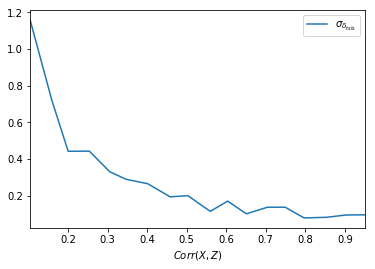

In [9]:
df.plot(x='$Corr(X, Z)$', y='$\sigma_{\delta_{tsls}}$')

You can show that TSLS is one interpretation of the Wald estimator, so they agree with each other! The same issues regarding the strength of the instrument apply here.